# Unsupervised Learning notebook

This notebook will be for finding inferences on the given obesity dataset with unsupervised learning algorithms K-Means and Hierarchical clustering

#### Initial import and data check

In [1]:
# initial imports
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# import obesity data
obesity_df = pd.read_csv("assignment_dataset/ObesityDataSet_raw_and_data_sinthetic.csv")

In [3]:
obesity_df.shape

(2111, 17)

In [4]:
obesity_df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


#### Set feature types

We need to define what types of variables are features are so we can transform them correctly for the distance algorithms

In [5]:
# Define feature groups based on data types
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
binary_features = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
ordinal_features = ['CAEC', 'CALC']
nominal_features = ['Gender', 'MTRANS']

In [6]:
# Check for 16 features
len(numerical_features) + len(binary_features) + len(ordinal_features) + len(nominal_features)

16

#### Encodings

In [7]:
# work on copy
encoded_df = obesity_df.copy()

##### Binary Features

In [8]:
binary_map = {'yes':1, 'no':0}

for col in binary_features:
    encoded_df[col] = encoded_df[col].map(binary_map).astype(int)

In [9]:
encoded_df[binary_features]

,family_history_with_overweight,FAVC,SMOKE,SCC
0,1,0,0,0
1,1,0,1,1
2,1,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
2106,1,1,0,0
2107,1,1,0,0
2108,1,1,0,0
2109,1,1,0,0


##### Ordinal features

For the two ordinal features

no < sometimes < frequently < always -> 0, 1, 2, 3

In [10]:
ordinal_map = {
    'no':0,
    'Sometimes':1,
    'Frequently':2,
    'Always':3
}

for col in ordinal_features:
    encoded_df[col] = encoded_df[col].map(ordinal_map)

In [11]:
encoded_df[ordinal_features]

,CAEC,CALC
0,1,0
1,1,1
2,1,2
3,1,2
4,1,1
...,...,...
2106,1,1
2107,1,1
2108,1,1
2109,1,1


##### Nominal features - One hot encoding

Use one hot encoding for the nominal features and drop first. Absense of any 1 value implies the dropped value

In [12]:
encoded_df = pd.get_dummies(encoded_df, columns=nominal_features, drop_first=True)

In [13]:
encoded_df.columns.to_list()

['Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'NObeyesdad',
 'Gender_Male',
 'MTRANS_Bike',
 'MTRANS_Motorbike',
 'MTRANS_Public_Transportation',
 'MTRANS_Walking']

#### Create feature dataset - a.k.a X

In [14]:
# Get all feature columns except NObeyesdad
feature_cols = [col for col in encoded_df.columns if col != 'NObeyesdad']

len(feature_cols) # should be 19

19

In [15]:
X = encoded_df[feature_cols]

In [16]:
X.shape # should be 2111 rows by 19 columns

(2111, 19)

#### Scale X

In [17]:
# Scale all features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame to keep track of feature names
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

In [18]:
X_scaled_df.shape

(2111, 19)

In [19]:
X_scaled_df.head()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Gender_Male,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.522124,-0.875589,-0.862558,0.472291,-2.759769,-0.785019,0.404153,-0.300346,-0.145900,-0.013073,-0.218272,-1.188039,0.561997,-1.419172,-1.011914,-0.05768,-0.072375,0.579721,-0.165078
1,-0.522124,-1.947599,-1.168077,0.472291,-2.759769,1.088342,0.404153,-0.300346,6.853997,1.618759,4.581439,2.339750,-1.080625,0.521160,-1.011914,-0.05768,-0.072375,0.579721,-0.165078
2,-0.206889,1.054029,-0.366090,0.472291,-2.759769,-0.785019,0.404153,-0.300346,-0.145900,-0.013073,-0.218272,1.163820,0.561997,2.461491,0.988227,-0.05768,-0.072375,0.579721,-0.165078
3,0.423582,1.054029,0.015808,-2.117337,-2.759769,1.088342,0.404153,-0.300346,-0.145900,-0.013073,-0.218272,1.163820,-1.080625,2.461491,0.988227,-0.05768,-0.072375,-1.724969,6.057758
4,-0.364507,0.839627,0.122740,-2.117337,-2.759769,-0.785019,-2.167023,-0.300346,-0.145900,-0.013073,-0.218272,-1.188039,-1.080625,0.521160,0.988227,-0.05768,-0.072375,0.579721,-0.165078


In [20]:
# Check scaling has been correct. Mean of 0 and sd of 1
X_scaled_df.describe()

,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Gender_Male,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
count,2111.000000,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2.111000e+03,2111.000000
mean,0.000000,-5.385449e-16,-5.385449e-16,-8.078174e-17,1.346362e-16,-1.346362e-17,4.964711e-16,-1.884907e-16,-2.019544e-17,1.077090e-16,-6.731812e-17,2.692725e-17,-1.346362e-17,5.048859e-17,-5.385449e-17,-1.009772e-17,2.019544e-17,6.731812e-17,0.000000
std,1.000237,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237e+00,1.000237
min,-1.625448,-2.698006e+00,-1.817304e+00,-2.117337e+00,-2.759769e+00,-2.658379e+00,-2.167023e+00,-2.435125e+00,-1.459003e-01,-1.644905e+00,-2.182720e-01,-1.188039e+00,-1.080625e+00,-1.419172e+00,-1.011914e+00,-5.768012e-02,-7.237469e-02,-1.724969e+00,-0.165078
25%,-0.688066,-7.683883e-01,-8.062914e-01,4.722913e-01,3.623491e-01,-7.850187e-01,-3.456952e-02,-3.003456e-01,-1.459003e-01,-6.905894e-01,-2.182720e-01,-1.041630e+00,-1.080625e+00,-1.419172e+00,-1.011914e+00,-5.768012e-02,-7.237469e-02,-1.724969e+00,-0.165078
50%,-0.241897,-1.263207e-02,-1.369510e-01,4.722913e-01,3.623491e-01,-6.283450e-02,4.041527e-01,-3.003456e-01,-1.459003e-01,-1.307326e-02,-2.182720e-01,-1.210937e-02,-5.341135e-02,5.211595e-01,9.882266e-01,-5.768012e-02,-7.237469e-02,5.797206e-01,-0.165078
75%,0.265964,7.159595e-01,7.960531e-01,4.722913e-01,3.623491e-01,1.088342e+00,4.041527e-01,-3.003456e-01,-1.459003e-01,7.659959e-01,-2.182720e-01,7.718565e-01,5.619968e-01,5.211595e-01,9.882266e-01,-5.768012e-02,-7.237469e-02,5.797206e-01,-0.165078
max,5.782584,2.983646e+00,3.300136e+00,4.722913e-01,3.623491e-01,1.088342e+00,1.689740e+00,3.969213e+00,6.853997e+00,1.618759e+00,4.581439e+00,2.339750e+00,2.204618e+00,4.401822e+00,9.882266e-01,1.733700e+01,1.381699e+01,5.797206e-01,6.057758


## K-Means

Start the k-means algorithm training.

We'll test k from 2 to 10. We know given classes are 7.

In [21]:
# Set score storage and k numbers
inertias = []
silhouette_scores = []
homogeneity_scores = []
completeness_scores = []
k_range = range(2,11)

In [22]:
# Run k means and save results
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=13) # unlucky for some
    kmeans.fit(X_scaled)
    labels = kmeans.labels_

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    homogeneity_scores.append(homogeneity_score(encoded_df['NObeyesdad'], labels))
    completeness_scores.append(completeness_score(encoded_df['NObeyesdad'], labels))

In [23]:
# results DataFrame
results_df = pd.DataFrame({
    'k': k_range,
    'Inertia': inertias,
    'Silhouette': silhouette_scores,
    'Homogeneity': homogeneity_scores,
    'Completeness': completeness_scores
})

Check results

In [24]:
results_df

,k,Inertia,Silhouette,Homogeneity,Completeness
0,2,36322.612643,0.211775,0.129112,0.428288
1,3,33765.239858,0.140294,0.140177,0.261060
2,4,31542.890068,0.143382,0.151917,0.259176
3,5,29681.758384,0.098845,0.263896,0.355983
4,6,27533.878825,0.110885,0.264125,0.351749
5,7,25847.454858,0.129723,0.278539,0.341662
6,8,24055.861013,0.116954,0.273889,0.387262
7,9,21872.279760,0.150242,0.279522,0.327811
8,10,20748.433927,0.157624,0.329357,0.341589


Plot results

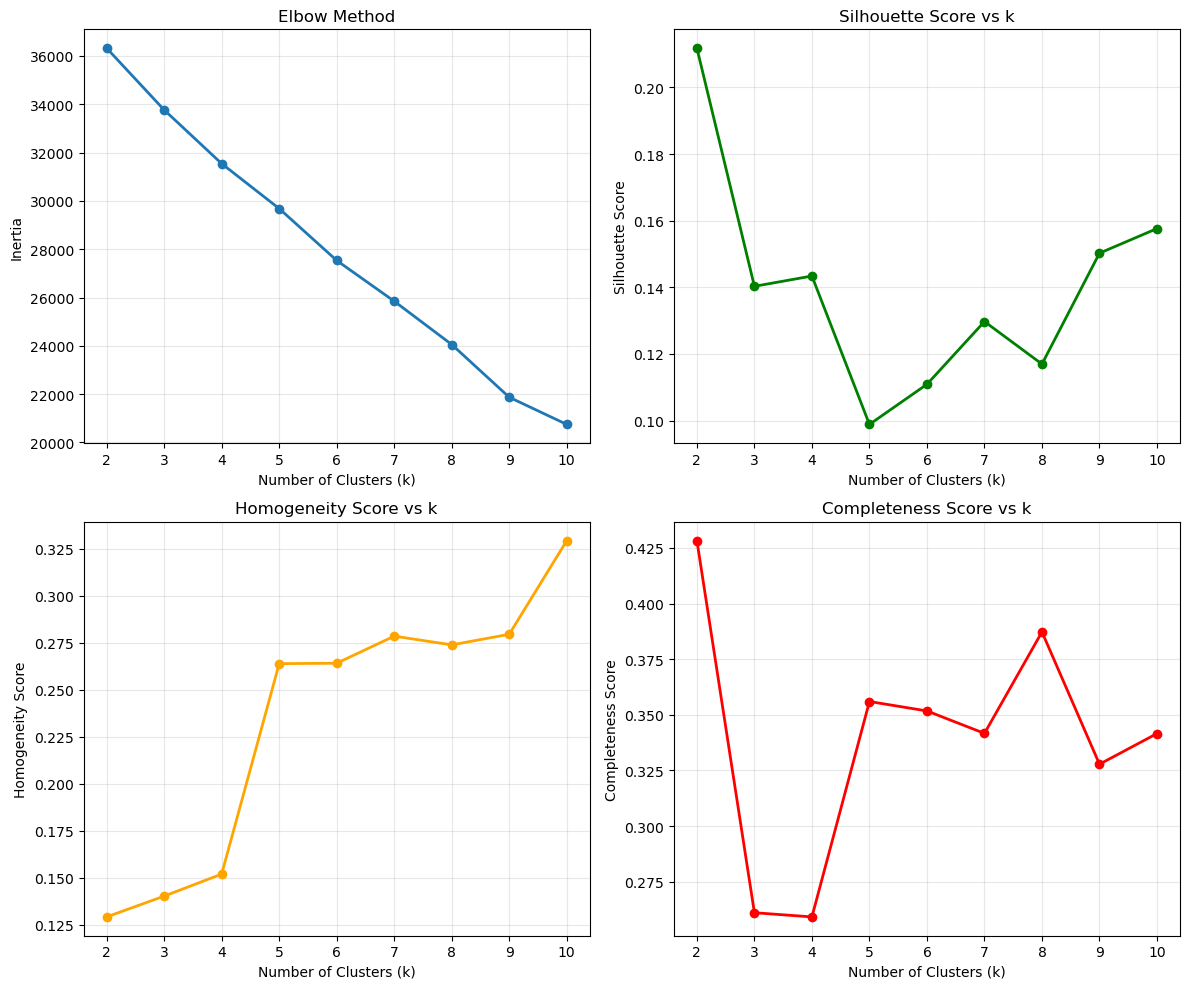

In [25]:
# Create subplots for the metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Elbow plot (Inertia)
axes[0, 0].plot(results_df['k'], results_df['Inertia'], marker='o', linewidth=2)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette Score
axes[0, 1].plot(results_df['k'], results_df['Silhouette'], marker='o', color='green', linewidth=2)
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score vs k')
axes[0, 1].grid(True, alpha=0.3)

# Homogeneity Score
axes[1, 0].plot(results_df['k'], results_df['Homogeneity'], marker='o', color='orange', linewidth=2)
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Homogeneity Score')
axes[1, 0].set_title('Homogeneity Score vs k')
axes[1, 0].grid(True, alpha=0.3)

# Completeness Score
axes[1, 1].plot(results_df['k'], results_df['Completeness'], marker='o', color='red', linewidth=2)
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Completeness Score')
axes[1, 1].set_title('Completeness Score vs k')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Try specifically k = 7?

In [26]:
# Fit K-means with k=7 match target class numbers
kmeans_final = KMeans(n_clusters=7, n_init=10, random_state=13)
kmeans_final.fit(X_scaled)

# Get cluster labels
cluster_labels = kmeans_final.labels_

# Add cluster labels to our encoded dataframe for analysis
encoded_df['Cluster'] = cluster_labels

print(f"Cluster distribution:")
print(encoded_df['Cluster'].value_counts().sort_index())
print(f"\nFinal metrics for k=7:")
print(f"Inertia: {kmeans_final.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.4f}")
print(f"Homogeneity Score: {homogeneity_score(encoded_df['NObeyesdad'], cluster_labels):.4f}")
print(f"Completeness Score: {completeness_score(encoded_df['NObeyesdad'], cluster_labels):.4f}")

Cluster distribution:
Cluster
0    374
1    713
2    400
3     88
4     11
5     61
6    464
Name: count, dtype: int64

Final metrics for k=7:
Inertia: 25847.45
Silhouette Score: 0.1297
Homogeneity Score: 0.2785
Completeness Score: 0.3417


The results aren't exactly promising.

We have 4 fairly well popualted clusters that have pulled massively from the other 3.

We can perhaps try using PCA to reduce the dimensionality and help get more defined clusters.

## Principle Component Analysis

In [27]:
# Apply PCA to see variance explained
pca_full = PCA()
pca_full.fit(X_scaled)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",None
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized S

In [28]:
# Get explained variance and put in dataframe
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

variance_df = pd.DataFrame({
    'Component': range(1, len(explained_variance) + 1),
    'Variance_Explained': explained_variance,
    'Cumulative_Variance': cumulative_variance
})

print("Variance explained by each component:")
print(variance_df.head(10))
print(f"\nVariance explained by first 2 components: {cumulative_variance[1]:.4f}")
print(f"Variance explained by first 3 components: {cumulative_variance[2]:.4f}")

Variance explained by each component:
   Component  Variance_Explained  Cumulative_Variance
0          1            0.136201             0.136201
1          2            0.095966             0.232167
2          3            0.092325             0.324492
3          4            0.072273             0.396765
4          5            0.060258             0.457024
5          6            0.057689             0.514713
6          7            0.054991             0.569704
7          8            0.052554             0.622258
8          9            0.051189             0.673447
9         10            0.048055             0.721501

Variance explained by first 2 components: 0.2322
Variance explained by first 3 components: 0.3245


In [29]:
variance_df

,Component,Variance_Explained,Cumulative_Variance
0,1,0.136201,0.136201
1,2,0.095966,0.232167
2,3,0.092325,0.324492
3,4,0.072273,0.396765
4,5,0.060258,0.457024
5,6,0.057689,0.514713
6,7,0.054991,0.569704
7,8,0.052554,0.622258
8,9,0.051189,0.673447
9,10,0.048055,0.721501


Nothing is really standingn out

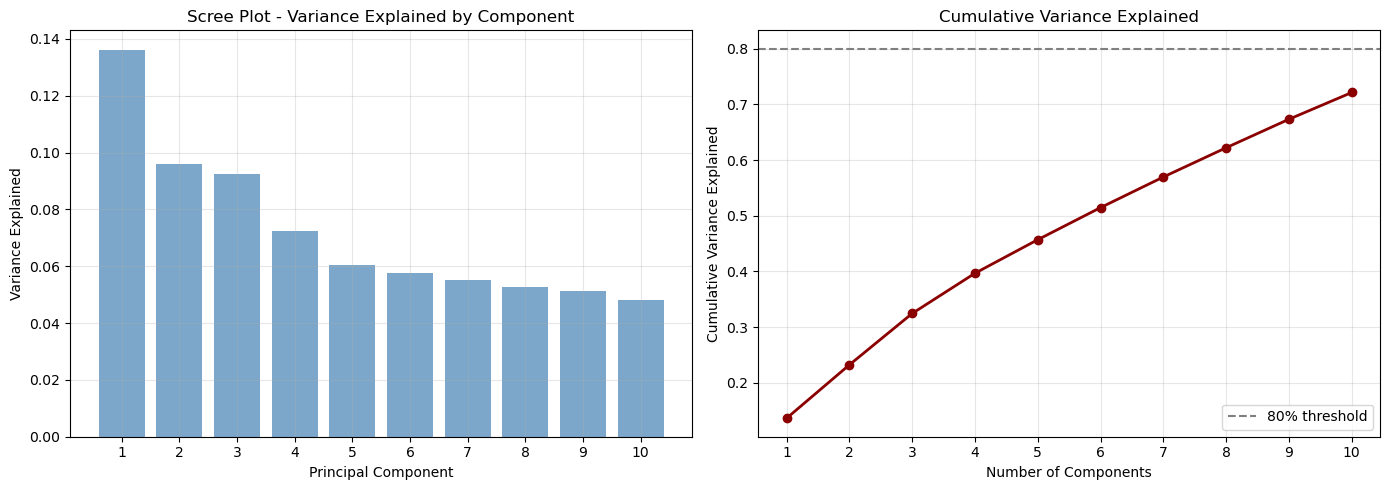

In [30]:
# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, 11), explained_variance[:10], alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Scree Plot - Variance Explained by Component')
axes[0].set_xticks(range(1, 11))
axes[0].grid(True, alpha=0.3)

# Cumulative variance plot
axes[1].plot(range(1, 11), cumulative_variance[:10], marker='o', linewidth=2, color='darkred')
axes[1].axhline(y=0.8, color='gray', linestyle='--', label='80% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].set_xticks(range(1, 11))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Try with 2 components and see how the groups are

In [31]:
# Fit PCA with 2 components for visualization
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(
    X_pca_2d,
    columns=['PC1', 'PC2']
)

# Add the cluster labels and true obesity class
pca_df['Cluster'] = cluster_labels
pca_df['True_Class'] = encoded_df['NObeyesdad'].values

print(f"PCA 2D shape: {pca_df.shape}")
print(f"\nVariance explained by 2 components: {pca_2d.explained_variance_ratio_.sum():.4f}")
print("\nFirst few rows:")
print(pca_df.head())

PCA 2D shape: (2111, 4)

Variance explained by 2 components: 0.2322

First few rows:
        PC1       PC2  Cluster           True_Class
0 -1.959550 -0.080389        6        Normal_Weight
1 -2.556055  1.527960        3        Normal_Weight
2  0.565580  1.915129        1        Normal_Weight
3 -0.173069  2.896826        5   Overweight_Level_I
4 -1.032092  0.340513        6  Overweight_Level_II


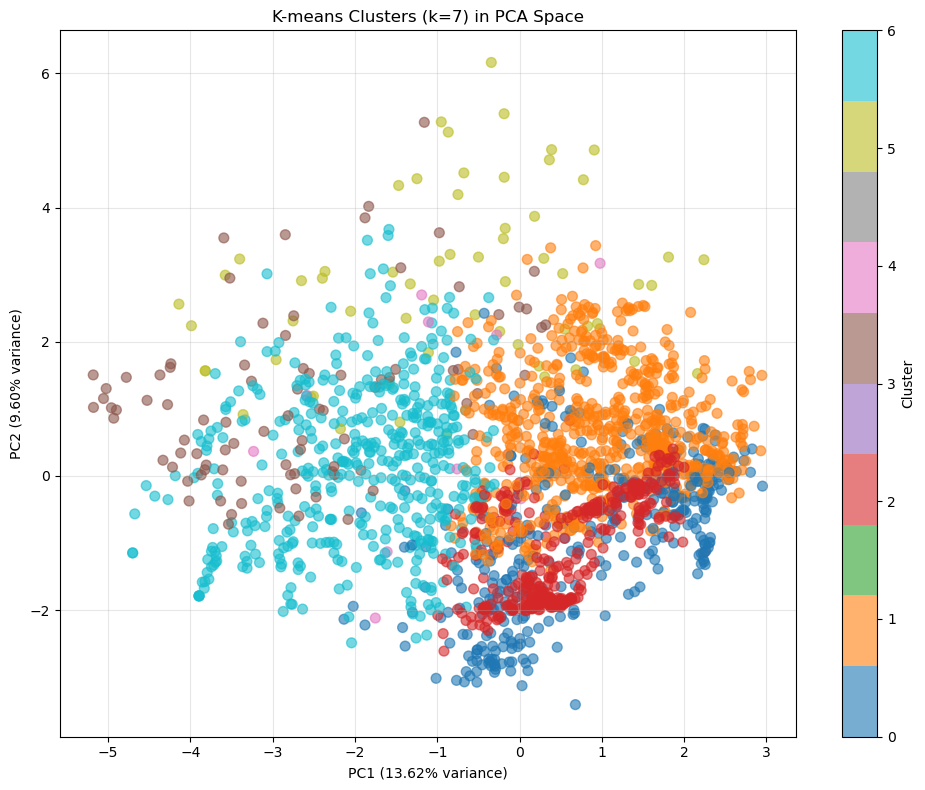

In [32]:
# Visualize K-means clusters in PCA space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'],
                     c=pca_df['Cluster'],
                     cmap='tab10',
                     alpha=0.6,
                     s=50)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('K-means Clusters (k=7) in PCA Space')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

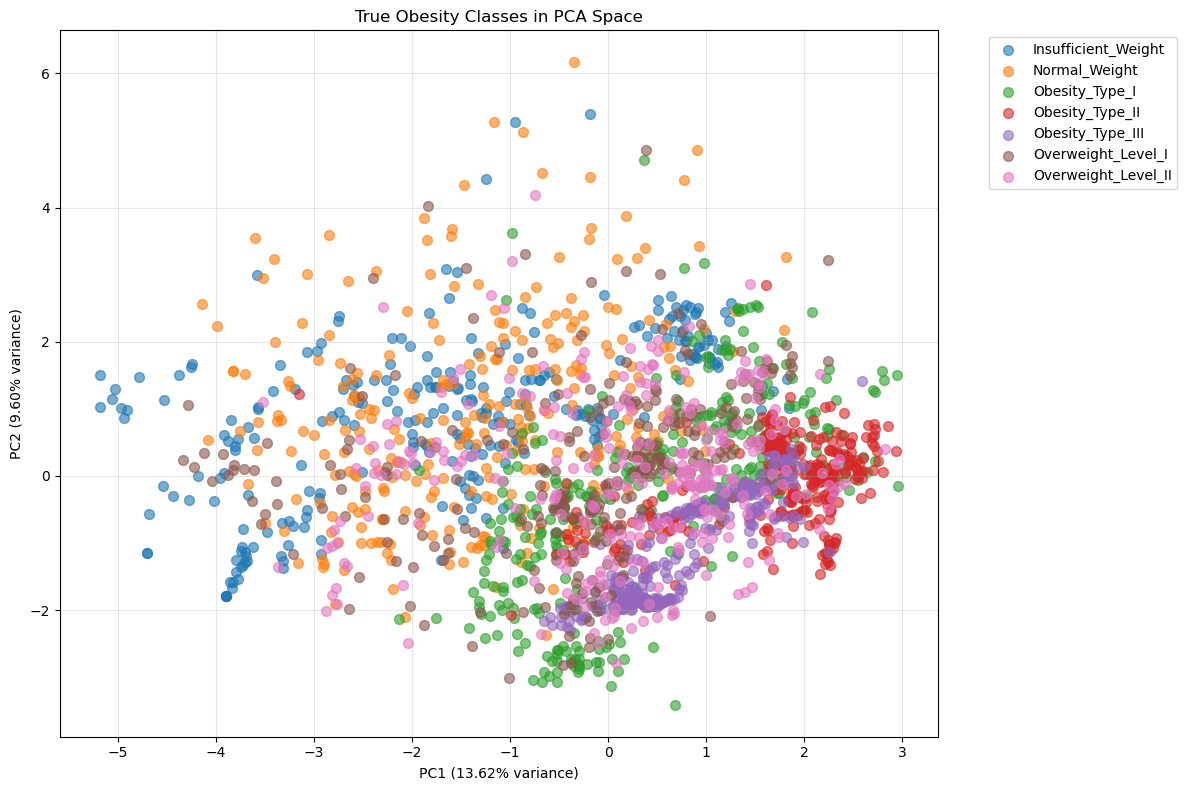

In [33]:
# Visualize true obesity classes in PCA space
plt.figure(figsize=(12, 8))

# Create a color map for the 7 obesity classes
obesity_classes = pca_df['True_Class'].unique()
colors = plt.cm.tab10(range(len(obesity_classes)))

for idx, obesity_class in enumerate(sorted(obesity_classes)):
    mask = pca_df['True_Class'] == obesity_class
    plt.scatter(pca_df.loc[mask, 'PC1'],
               pca_df.loc[mask, 'PC2'],
               label=obesity_class,
               alpha=0.6,
               s=50)

plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('True Obesity Classes in PCA Space')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()